In [33]:
%autosave 60
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib 
import matplotlib.font_manager
import scipy.stats


Autosaving every 60 seconds


In [34]:
barplot = True
barplot_pps = 4000

confidence = 95
results_dir = 'results'

nm_map = {
    'aggregation_strategy': u'Aggregation Strategy',
    'avg_delay': u'Average Aggregation Delay (ms)',    
    'data_per_pkt': u'Data per Packet',
    'goodput': u'Goodput (kB/s)',
    'gt': u'G/T (%)',
    'pkt_loss': u'Packet Loss (%)', 
    'pkt_recv': u'Received Packets',
    'pkt_send': u'Sent Packets',
    'pps_recv': u'Gateway Received Packets (pps)', 
    'pps_send': u'Router Received Packet (pps)', 
    'pps_tcpreplay': u'Packets Sent (pps)',
    'sample_int': u'Sampling Interval (s)', 
    'throughput': u'Throughput (kB/s)',
    'topology': u'Topology'
}
nm_keys = nm_map.keys()
nm_keys.sort()

df = pd.concat([
    pd.read_json('results/switch.json', orient='records', typ='frame'), 
    pd.read_json('results/iotp.json', orient='records', typ='frame')
])
df = df[ (df['data_per_pkt'] == 1) & (df['topology'] == 'wc') ]
if barplot:
    df = df[ (df['pps_tcpreplay'] == barplot_pps) ]

df.set_axis(map(lambda x: nm_map[x], nm_keys), axis=1, inplace=True)

df_not_l2 = df[df[nm_map['aggregation_strategy']] != "L2 Switch"]
df_l2_iotp10 = df[(df[nm_map['aggregation_strategy']] == "L2 Switch") | (df[nm_map['aggregation_strategy']] == "IOTP DT 10")]

In [35]:
# kurtosis
# < 0    The peak is lower and broader, lack of outliers
# > 0    Peak is higher and sharper, profusion of outliers
# skewness
# < |0.5|           fairly simmetrical
# [|0.5|, |1.0|]    moderate skew
# > |1.0|           high skew
def calculate_descriptive_stat(df):
    kur_skew = pd.concat([df.kurtosis() - 3, df.skew()], axis=1, keys=[u'Kurtosis Normalizado',u'Skewness']).transpose()
    stat = df.describe()
    conf_var = scipy.stats.t.ppf((1 + confidence/100.) / 2., stat.loc['count']-1) * stat.loc['std']
    conf_int = pd.concat([stat.loc['mean']-conf_var, stat.loc['mean']+conf_var], axis=1, keys=[u'Intervalo de Confiança - Limite Inferior',u'Intervalo de Confiança - Limite Superior']).transpose()
    stat.set_axis([u'Amostragem', u'Média', u'Desvio Padrão', u'Mínimo', u'1º Quartil', u'2º Quartil', u'3º Quartil', u'Máximo'], axis=0, inplace=True)
    stat = pd.concat([stat, conf_int])
    stat = pd.concat([stat, kur_skew])
    return stat

# calculate_descriptive_stat(df.loc[df[nm_map['aggregation_strategy']] == u'L2 Switch'])

In [36]:
dpi = 400
capsize = 4.5

# style (defines grid style): darkgrid, whitegrid, dark, white, ticks
# palette (defines the color pallete): deep, muted, bright, pastel, dark, colorblind
# font: "serif", "sans-serif"
sns.set(
    context="notebook", style="whitegrid", palette="muted", 
    font=u"arial,Verdana,Noto Sans,Times New Roman,serif,sans-serif", 
    font_scale=1.15, 
    rc={"lines.linewidth": 1.25}
)

def get_matplotlib_available_fonts():
    matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

def save_plot(filename, sns_axis):    
    # make room for the xlabel in the saved figure
    plt.gcf().subplots_adjust(left=0.17, bottom=0.17)
    # save files    
    sns_axis.figure.savefig('%s/%s.png' %(results_dir, filename), format='png', dpi=dpi)

def set_scale(ax, scale, scale_lim):    
    if (scale[0] == 'log'):
        ax.set_xscale('log')
    if (scale[1] == 'log'):
        ax.set_yscale('log')    
    if scale_lim[0]:
        ax.set(xlim=scale_lim[0])
    if scale_lim[1]:
        ax.set(ylim=scale_lim[1])        

def show_lineplot(df, filename, x, y, category, ax=None, scale=[None, None], scale_lim=[None, None], size=(6,6)):
    if size:
        plt.figure(figsize=size)
    ax = sns.lineplot(x=nm_map[x], y=nm_map[y], ax=ax, legend="brief",             
            hue=nm_map[category], style=nm_map[category],
            markers=True, dashes=False, 
            err_style='bars', estimator='mean', ci=confidence, err_kws={'capsize':capsize},
            data=df)
    set_scale(ax, scale=scale, scale_lim=scale_lim)
    save_plot(filename, ax)
    return ax
    
def show_barplot(df, filename, x, y, ax=None, scale=[None, None], scale_lim=[None, None], size=(6,6)):
    if size:
        plt.figure(figsize=size)
    ax = sns.barplot(x=nm_map[x], y=nm_map[y], ax=ax, 
                     estimator=np.mean, ci=confidence, capsize=capsize/18.0,
                     data=df)
    set_scale(ax, scale=scale, scale_lim=scale_lim)
    save_plot(filename, ax)
    return ax


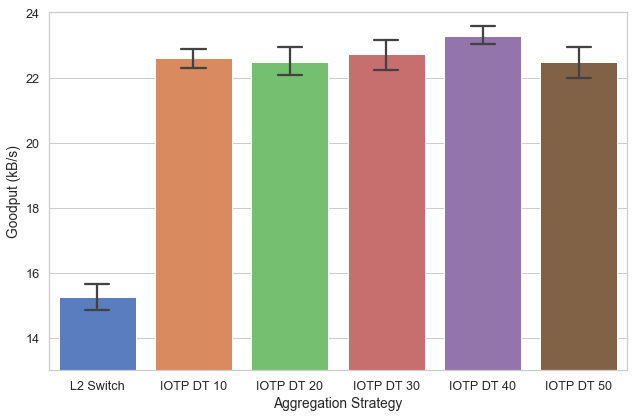

In [37]:
if barplot:
    ax = show_barplot(df, 'goodput_barplot', x='aggregation_strategy', y='goodput', size=(11,7), scale_lim=[None, (13,24)])
else:
    ax = show_lineplot(df_l2_iotp10, 'goodput_l2_lineplot', x='pps_tcpreplay', y='goodput', category='aggregation_strategy')

In [38]:
if not barplot:
    ax = show_lineplot(df_not_l2, 'goodput_iotp', x='pps_tcpreplay', y='goodput', category='aggregation_strategy')

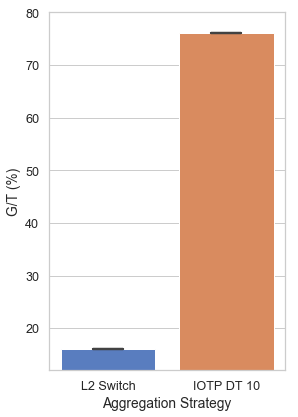

In [39]:
if barplot:
    ax = show_barplot(df_l2_iotp10, 'gt_l2_barplot', x='aggregation_strategy', y='gt', size=(4.5,7), scale_lim=[None, (12,80)])
else:
    ax = show_lineplot(df_l2_iotp10, 'gt_l2_lineplot', x='pps_tcpreplay', y='gt', category='aggregation_strategy')

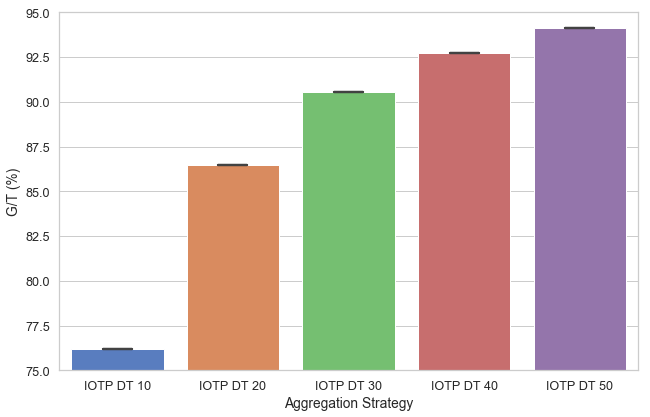

In [40]:
if barplot:
    ax = show_barplot(df_not_l2, 'gt_iotp_barplot', x='aggregation_strategy', y='gt', size=(11,7), scale_lim=[None, (75,95)])
else:
    ax = show_lineplot(df_not_l2, 'gt_iotp_lineplot', x='pps_tcpreplay', y='gt', category='aggregation_strategy')

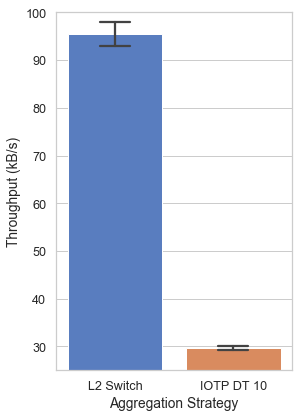

In [41]:
if barplot:
    ax = show_barplot(df_l2_iotp10, 'throughput_l2_barplot', x='aggregation_strategy', y='throughput', size=(4.5,7), scale_lim=[None, (25,100)])
else:
    ax = show_lineplot(df_l2_iotp10, 'throughput_l2_lineplot', x='pps_tcpreplay', y='throughput', category='aggregation_strategy')

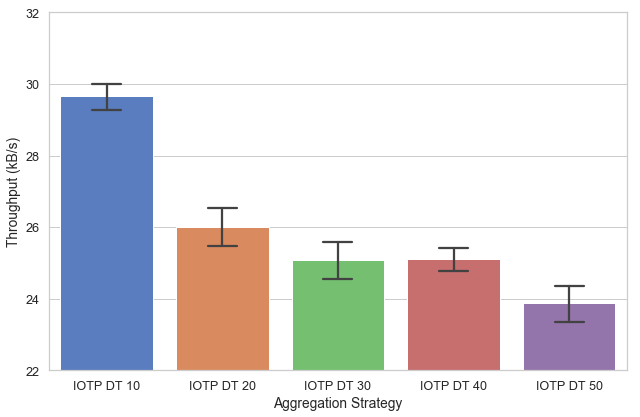

In [42]:
if barplot:
    ax = show_barplot(df_not_l2, 'throughput_iotp_barplot', x='aggregation_strategy', y='throughput', size=(11,7), scale_lim=[None, (22,32)])
else:
    ax = show_lineplot(df_not_l2, 'throughput_iotp_lineplot', x='pps_tcpreplay', y='throughput', category='aggregation_strategy')

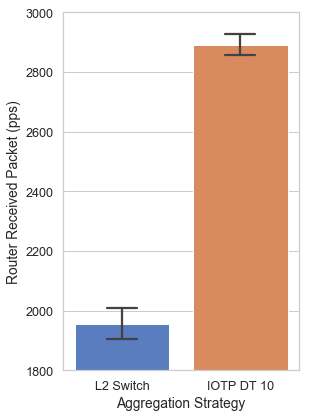

In [43]:
if barplot:
    ax = show_barplot(df_l2_iotp10, 'pps_recv_l2_barplot', x='aggregation_strategy', y='pps_send', size=(4.5,7), scale_lim=[None, (1800,3000)])
else:
    ax = show_lineplot(df_l2_iotp10, 'pps_recv_l2_lineplot', x='pps_tcpreplay', y='pps_send', category='aggregation_strategy')    

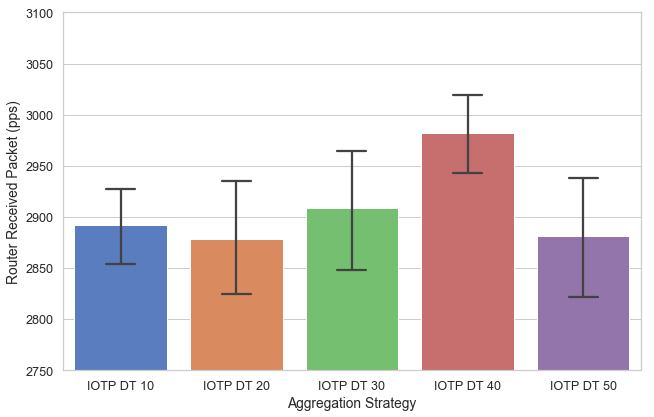

In [44]:
if barplot:
    ax = show_barplot(df_not_l2, 'pps_recv_iotp_barplot', x='aggregation_strategy', y='pps_send', size=(11,7), scale_lim=[None, (2750,3100)])
else:
    ax = show_lineplot(df_not_l2, 'pps_recv_iotp_lineplot', x='pps_tcpreplay', y='pps_send', category='aggregation_strategy')

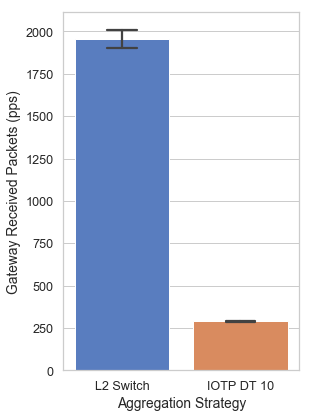

In [45]:
if barplot:
    ax = show_barplot(df_l2_iotp10, 'pps_send_l2_barplot', x='aggregation_strategy', y='pps_recv', size=(4.5,7), scale_lim=[None, None])
else:
    ax = show_lineplot(df_l2_iotp10, 'pps_send_l2_lineplot', x='pps_tcpreplay', y='pps_recv', category='aggregation_strategy')    

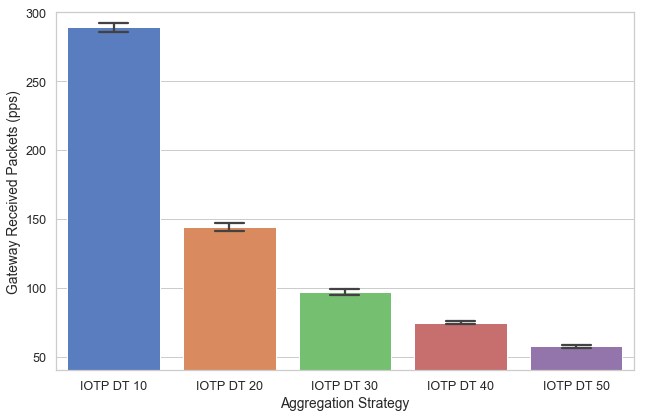

In [46]:
if barplot:
    ax = show_barplot(df_not_l2, 'pps_send_iotp_barplot', x='aggregation_strategy', y='pps_recv', size=(11,7), scale_lim=[None, (40,300)])
else:
    ax = show_lineplot(df_not_l2, 'pps_send_iotp_lineplot', x='pps_tcpreplay', y='pps_recv', category='aggregation_strategy')

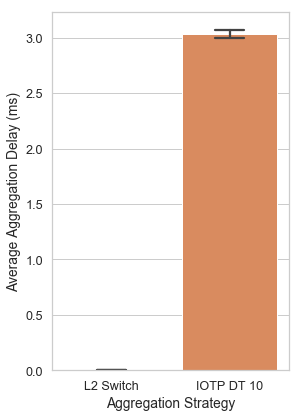

In [47]:
if barplot:
    ax = show_barplot(df_l2_iotp10, 'delay_l2_barplot', x='aggregation_strategy', y='avg_delay', size=(4.5,7), scale_lim=[None, None])
else:
    ax = show_lineplot(df_l2_iotp10, 'delay_l2_lineplot', x='pps_tcpreplay', y='avg_delay', category='aggregation_strategy')

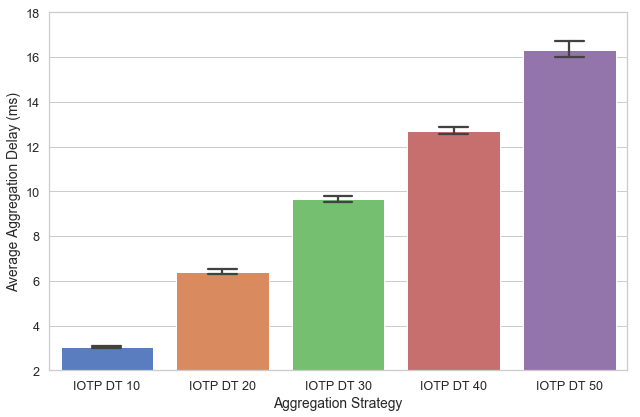

In [48]:
if barplot:
    ax = show_barplot(df_not_l2, 'delay_iotp_barplot', x='aggregation_strategy', y='avg_delay', size=(11,7), scale_lim=[None, (2,18)])
else:
    ax = show_lineplot(df_not_l2, 'delay_iotp_lineplot', x='pps_tcpreplay', y='avg_delay', category='aggregation_strategy')    